In [1]:
import ugradio
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from datetime import datetime
from datetime import timedelta
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
imf = ugradio.interf.Interferometer()
hpm = ugradio.hp_multi.HP_Multimeter()

In [11]:
def take_data(obs_length, time_per_iter, dt):
    
    """
    - obs_length: observation time (minutes)
    - time_per_iter: how long to wait before moving the telescope again (seconds)
    - dt: how often to read voltage (seconds) (time resolution of data)
    
    RETURNS
    - final_data[0]: array of voltages
    - final_data[1]: array of times
    """
    
    imf.stow() # stow telescope to initialize data collecting (in case someone else didn't stow)
    
    start_time = ugradio.timing.julian_date() # define start time of observation
    delta_jd = obs_length/(24*60) # convert obs_length to Julian date
    end_time = start_time + delta_jd # define when to end observation
    
    jd = ugradio.timing.julian_date() # default=now
    
    # input the time and will return the alt and az of the object
    def calc_pos(jd):
        ra, dec = ugradio.coord.sunpos(jd) # ra and dec coords
        lat, long, alt_nch = ugradio.nch.lat, ugradio.nch.lon, ugradio.nch.alt 
        alt, az = ugradio.coord.get_altaz(ra, dec, jd, lat, long, alt_nch)
        return alt, az # alt, az of the object right now
    
    # point the telescope to initial object position
    alt, az = calc_pos(jd)
    print('Moving to initial object position...')
    imf.point(alt, az)
    
    i = 0
    hpm.start_recording(dt)
    while jd < end_time: 
        print(i, "iteration")
        # how often to move the telescope    
        time.sleep(time_per_iter) # keep telescope at this position for this amount of time -- collects data
        jd = ugradio.timing.julian_date() # recalculate JD
        
        if i%10 == 0: # saving the data frequently in case of error
            final_data = hpm.get_recording_data() # collect data
            np.save("final_data.npy", final_data) # dave data
            print('Saving data.')
            
        alt, az = calc_pos(jd) # recalculate the alt, az of the object at new JD
        
        #pointing
        try:
            imf.point(alt, az) # repoint the telescope to new alt, az, following the object's path
            print("Succesfully pointed, moved to new alt, az: {0:0.3f}, {1:0.3f}".format(alt, az))
            
        except:
            # check if object is in the northern sky
            if alt < ugradio.interf.ALT_MIN or alt > ugradio.interf.ALT_MAX: # if outside alt range
                alt = 180-alt # flip the telescope so that it doesn't error
                #alt -= 180 
                print('Outside altitude range so flipping.')
                
            if az < ugradio.interf.AZ_MIN or az > ugradio.interf.AZ_MAX: # if outside az range
                az += 180 # flip the telescope so that it doesn't error
                print('Outside azimuth range so flipping.')
                
            try:
                imf.point(alt, az) # point to new alt, az in the event that former alt, az was out of range
                print("Succesfully pointed, moved to new alt, az: {0:0.3f}, {1:0.3f}".format(alt, az))
                
            except: # if something else goes wrong
                print("That shit failed, saving data and moving to stow position.")
                break
            
        i+=1

            
    final_data = hpm.get_recording_data()
    np.save("final_data.npy", final_data)
    print('Final data saved.')
    
    hpm.end_recording() # end recording
    imf.stow() # stow telescope
    
    return final_data

In [21]:
take_data(60, 5, 0.1)

Moving to initial object position...
0 iteration
Saving data.
Succesfully pointed, moved to new alt, az: 45.750, 196.747
1 iteration
Succesfully pointed, moved to new alt, az: 45.743, 196.795
2 iteration
Succesfully pointed, moved to new alt, az: 45.735, 196.842
3 iteration
Succesfully pointed, moved to new alt, az: 45.728, 196.883
4 iteration
Succesfully pointed, moved to new alt, az: 45.720, 196.931
5 iteration
Succesfully pointed, moved to new alt, az: 45.713, 196.978
6 iteration
Succesfully pointed, moved to new alt, az: 45.705, 197.026
7 iteration
Succesfully pointed, moved to new alt, az: 45.697, 197.073
8 iteration
Succesfully pointed, moved to new alt, az: 45.689, 197.120
9 iteration
Succesfully pointed, moved to new alt, az: 45.681, 197.168
10 iteration
Saving data.
Succesfully pointed, moved to new alt, az: 45.673, 197.215
11 iteration
Succesfully pointed, moved to new alt, az: 45.666, 197.256
12 iteration
Succesfully pointed, moved to new alt, az: 45.659, 197.297
13 iteratio

Succesfully pointed, moved to new alt, az: 44.814, 201.692
112 iteration
Succesfully pointed, moved to new alt, az: 44.804, 201.738
113 iteration
Succesfully pointed, moved to new alt, az: 44.796, 201.778
114 iteration
Succesfully pointed, moved to new alt, az: 44.786, 201.824
115 iteration
Succesfully pointed, moved to new alt, az: 44.776, 201.869
116 iteration
Succesfully pointed, moved to new alt, az: 44.766, 201.915
117 iteration
Succesfully pointed, moved to new alt, az: 44.757, 201.955
118 iteration
Succesfully pointed, moved to new alt, az: 44.747, 202.001
119 iteration
Succesfully pointed, moved to new alt, az: 44.737, 202.046
120 iteration
Saving data.
Succesfully pointed, moved to new alt, az: 44.727, 202.092
121 iteration
Succesfully pointed, moved to new alt, az: 44.717, 202.138
122 iteration
Succesfully pointed, moved to new alt, az: 44.706, 202.183
123 iteration
Succesfully pointed, moved to new alt, az: 44.696, 202.229
124 iteration
Succesfully pointed, moved to new alt,

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/global/lib/python3.6/site-packages/ugradio/hp_multi.py", line 67, in _read_thread
    v,t = self.read_voltage(return_time=True)
  File "/home/global/lib/python3.6/site-packages/ugradio/hp_multi.py", line 49, in read_voltage
    s.connect(self.hostport)
TimeoutError: [Errno 110] Connection timed out



Succesfully pointed, moved to new alt, az: 44.199, 204.347
174 iteration
Succesfully pointed, moved to new alt, az: 44.188, 204.391
175 iteration
Succesfully pointed, moved to new alt, az: 44.177, 204.436
176 iteration
Succesfully pointed, moved to new alt, az: 44.166, 204.481
177 iteration
Succesfully pointed, moved to new alt, az: 44.155, 204.526
178 iteration
Succesfully pointed, moved to new alt, az: 44.144, 204.571
179 iteration
Succesfully pointed, moved to new alt, az: 44.133, 204.615
180 iteration
Saving data.
Succesfully pointed, moved to new alt, az: 44.121, 204.660
181 iteration
Succesfully pointed, moved to new alt, az: 44.110, 204.705
182 iteration
Succesfully pointed, moved to new alt, az: 44.100, 204.744
183 iteration
Succesfully pointed, moved to new alt, az: 44.089, 204.788
184 iteration
Succesfully pointed, moved to new alt, az: 44.079, 204.827
185 iteration
Succesfully pointed, moved to new alt, az: 44.067, 204.878
186 iteration
Succesfully pointed, moved to new alt,

Succesfully pointed, moved to new alt, az: 42.927, 208.978
285 iteration
Succesfully pointed, moved to new alt, az: 42.915, 209.015
286 iteration
Succesfully pointed, moved to new alt, az: 42.904, 209.052
287 iteration
Succesfully pointed, moved to new alt, az: 42.893, 209.089
288 iteration
Succesfully pointed, moved to new alt, az: 42.881, 209.127
289 iteration
Succesfully pointed, moved to new alt, az: 42.870, 209.164
290 iteration
Saving data.
Succesfully pointed, moved to new alt, az: 42.859, 209.201
291 iteration
Succesfully pointed, moved to new alt, az: 42.847, 209.238
292 iteration
Succesfully pointed, moved to new alt, az: 42.834, 209.281
293 iteration
Succesfully pointed, moved to new alt, az: 42.823, 209.318
294 iteration
Succesfully pointed, moved to new alt, az: 42.810, 209.360
295 iteration
Succesfully pointed, moved to new alt, az: 42.798, 209.397
296 iteration
Succesfully pointed, moved to new alt, az: 42.787, 209.434
297 iteration
Succesfully pointed, moved to new alt,

Succesfully pointed, moved to new alt, az: 41.487, 213.315
396 iteration
Succesfully pointed, moved to new alt, az: 41.472, 213.356
397 iteration
Succesfully pointed, moved to new alt, az: 41.457, 213.397
398 iteration
Succesfully pointed, moved to new alt, az: 41.445, 213.433
399 iteration
Succesfully pointed, moved to new alt, az: 41.432, 213.468
400 iteration
Saving data.
Succesfully pointed, moved to new alt, az: 41.419, 213.503
401 iteration
Succesfully pointed, moved to new alt, az: 41.404, 213.544
402 iteration
Succesfully pointed, moved to new alt, az: 41.389, 213.585
403 iteration
Succesfully pointed, moved to new alt, az: 41.376, 213.620
404 iteration
Succesfully pointed, moved to new alt, az: 41.363, 213.655
405 iteration
Succesfully pointed, moved to new alt, az: 41.348, 213.696
406 iteration
Succesfully pointed, moved to new alt, az: 41.334, 213.737
407 iteration
Succesfully pointed, moved to new alt, az: 41.319, 213.778
408 iteration
Succesfully pointed, moved to new alt,

(array([-8.50e-05, -9.00e-05, -9.00e-05, ...,  1.98e-04,  1.94e-04,
         1.94e-04]),
 array([1.64668719e+09, 1.64668719e+09, 1.64668719e+09, ...,
        1.64669077e+09, 1.64669077e+09, 1.64669077e+09]))

In [10]:
ugradio.coord??

In [3]:
data = np.load('final_data.npy')

In [4]:
volts = data[0]
times = data[1]

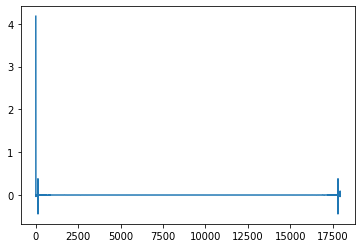

In [6]:
plt.figure()
plt.plot(np.fft.fft(volts))

In [29]:
times

array([1.64668719e+09, 1.64668719e+09, 1.64668719e+09, ...,
       1.64669077e+09, 1.64669077e+09, 1.64669077e+09])

In [8]:
freqs=np.fft.fftfreq(len(times),d=1/(10.7e9))
freqs

array([       0.        ,   596332.83174497,  1192665.66348994, ...,
       -1788998.49523491, -1192665.66348994,  -596332.83174497])

<IPython.core.display.Javascript object>


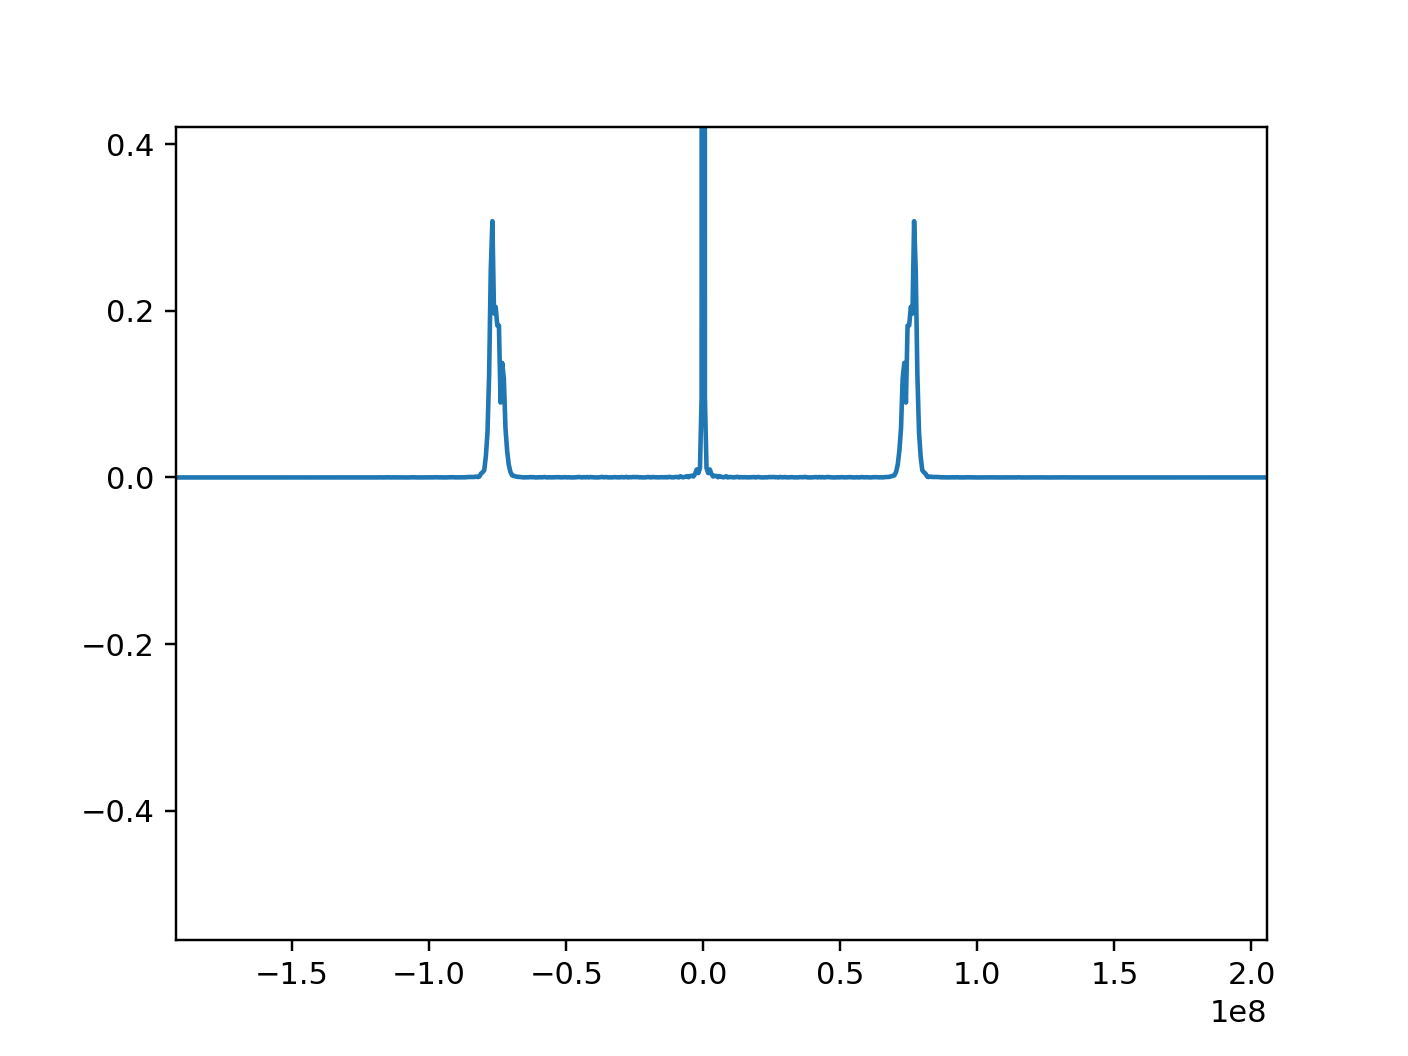

In [9]:
%matplotlib notebook
plt.plot(np.fft.fftshift(freqs),np.fft.fftshift(np.abs(np.fft.fft(volts))**2))
#plt.plot(freqs,volts)